# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [2]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      1.2.0
appnope                      0.1.3
asttokens                    2.0.8
astunparse                   1.6.3
autopep8                     1.6.0
backcall                     0.2.0
boto3                        1.24.24
botocore                     1.27.24
cachetools                   5.2.0
certifi                      2022.6.15
charset-normalizer           2.1.0
click                        8.1.3
commonmark                   0.9.1
cycler                       0.11.0
debugpy                      1.6.3
decorator                    4.4.2
dill                         0.3.5.1
entrypoints                  0.4
executing                    1.1.1
flatbuffers                  22.9.24
fonttools                    4.37.1
gast                         0.4.0
google-api-core              2.8.2
google-api-python-client     2.52.0
google-auth                  2.9.0
google-auth-httplib2         0.1.0
g

In [3]:
import tensorflow as tf
import os

2022-10-10 21:10:35.309534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4317 files belonging to 5 classes.


2022-10-10 21:10:47.337932: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

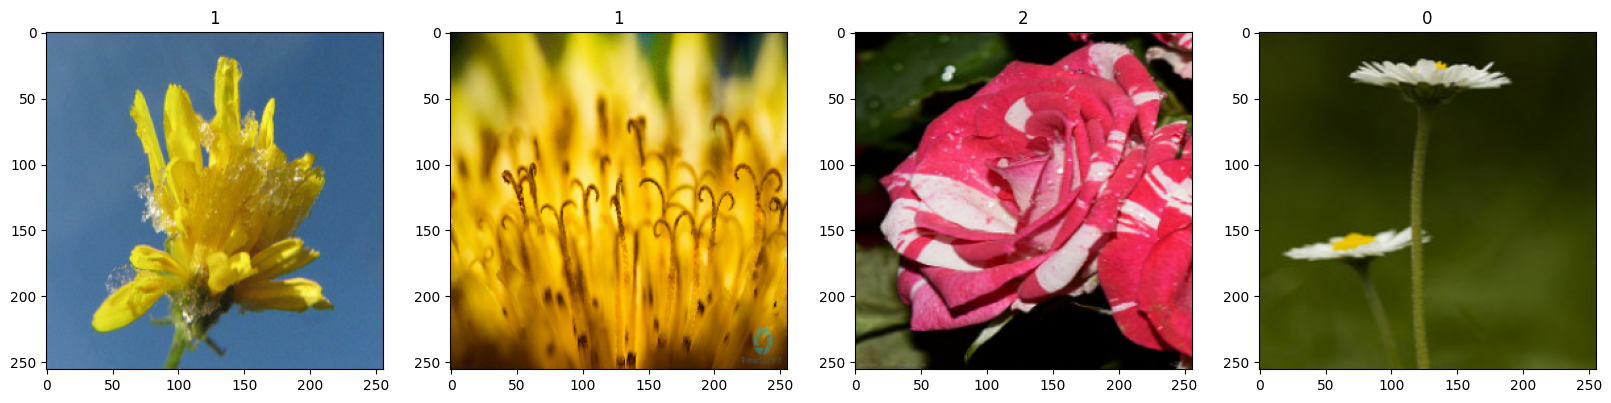

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[5.62316179e-01, 5.74080884e-01, 6.00367665e-01],
          [5.46262264e-01, 5.58026969e-01, 5.77634811e-01],
          [5.45206726e-01, 5.60224473e-01, 5.69209576e-01],
          ...,
          [3.85369271e-01, 4.83408481e-01, 6.04977131e-01],
          [3.52992386e-01, 4.34334308e-01, 5.62331736e-01],
          [2.86032766e-01, 3.67374688e-01, 5.02301157e-01]],
 
         [[5.73401809e-01, 5.85166514e-01, 6.04774356e-01],
          [5.55683434e-01, 5.68198502e-01, 5.86305618e-01],
          [5.53773880e-01, 5.64956486e-01, 5.75219989e-01],
          ...,
          [3.67401958e-01, 4.65441167e-01, 5.86341262e-01],
          [3.39200616e-01, 4.35493499e-01, 5.61366439e-01],
          [2.76618749e-01, 3.71083468e-01, 5.02297819e-01]],
 
         [[5.80277979e-01, 5.92042685e-01, 6.11650527e-01],
          [5.60349882e-01, 5.75459540e-01, 5.88377476e-01],
          [5.59444427e-01, 5.65237939e-01, 5.73705077e-01],
          ...,
          [3.51136684e-01, 4.46947515e-01, 5.6812

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

94

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [26]:
logdir='logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
94/94 [==============================] - 59s 609ms/step - loss: -7291878.0000 - accuracy: 0.2357 - val_loss: -60353680.0000 - val_accuracy: 0.2488
Epoch 2/20
94/94 [==============================] - 52s 554ms/step - loss: -1471138560.0000 - accuracy: 0.2370 - val_loss: -5725186048.0000 - val_accuracy: 0.2627
Epoch 3/20
94/94 [==============================] - 51s 543ms/step - loss: -27741536256.0000 - accuracy: 0.2364 - val_loss: -72211324928.0000 - val_accuracy: 0.2593
Epoch 4/20
94/94 [==============================] - 51s 541ms/step - loss: -192682213376.0000 - accuracy: 0.2357 - val_loss: -387205398528.0000 - val_accuracy: 0.2755
Epoch 5/20
94/94 [==============================] - 51s 544ms/step - loss: -796055175168.0000 - accuracy: 0.2374 - val_loss: -1418993467392.0000 - val_accuracy: 0.2558
Epoch 6/20
94/94 [==============================] - 51s 543ms/step - loss: -2369514635264.0000 - accuracy: 0.2367 - val_loss: -3617683931136.0000 - val_accuracy: 0.2604
Epoch 7/20

# 8. Plot Performance

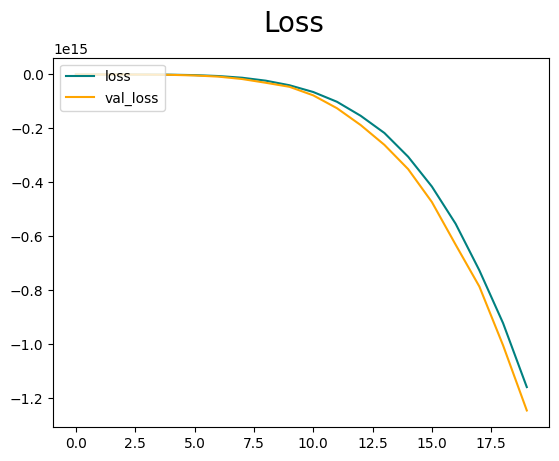

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

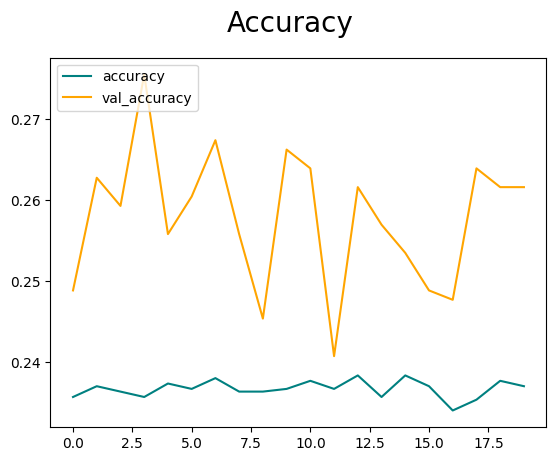

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 143ms/step


In [34]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.8317308, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.25240386, shape=(), dtype=float32)


# 10. Test

In [35]:
import cv2

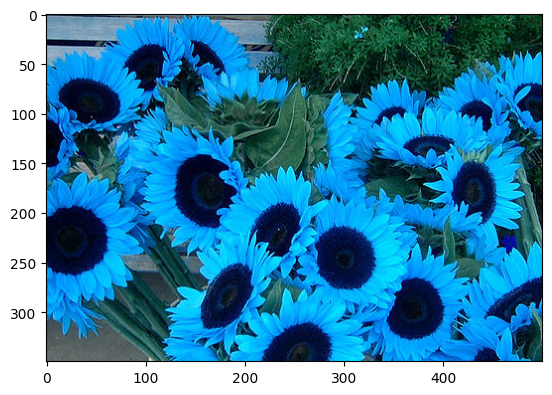

In [36]:
img = cv2.imread('8iAb9k4aT.jpg')
plt.imshow(img)
plt.show()

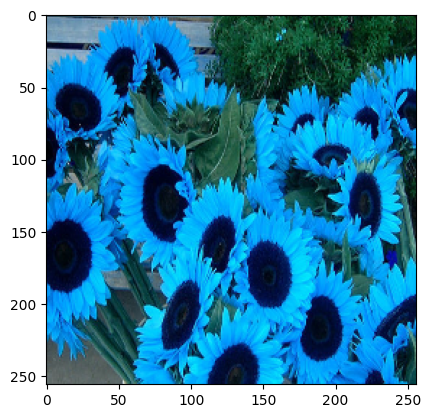

In [37]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [38]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 81ms/step


In [39]:
yhat

array([[1.]], dtype=float32)

In [40]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [41]:
from tensorflow.keras.models import load_model

In [42]:
model.save(os.path.join('models','imageclassifier.h5'))

In [43]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [44]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 80ms/step


array([[1.]], dtype=float32)